# Aula 16 - Validação Cruzada

## Máquinas De Previsão

"Artificial intelligence does the seemingly impossible, magically bringing machines to life--driving cars, trading stocks, and teaching children. But facing the sea change that AI will bring can be paralyzing. How should companies set strategies, governments design policies, and people plan their lives for a world so different from what we know? In the face of such uncertainty, many analysts either cower in fear or predict an impossibly sunny future."

**IA pode ser visto como conseguindo baratear o preço de previsões**. Colocando dessa forma, seu potencial fica mais claro:

* Previsão está no centro da tomada de decisão sob incerteza. 
* Previsão consegue aumentar a produtividade de sistemas, seja lendo documentos, dirigindo carros ou falando com clientes.

## Aprendizado Supervisionado

Nós estamos tentando partir de um conjunto de variáveis independentes e prever a variável dependente ou target. Nós fazemos isso estimando alguma função (modelo de aprendizado de máquina) `f(X) -> y`. Aqui, nós só queremos prever `y` bem e não nos importamos muito com `f`.


## Exemplo

Para começar, vamos tentar prever quantos exercícios de estatística um estudante faz dadas as horas de estudos.
De antemão, como vocês acham que é essa relação?

In [1]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [2]:
dataset = pd.read_parquet("/Users/matheus.facure/Downloads/produtividade.parquet")
print(dataset.shape)
dataset.head()

(1000, 2)


,horas,exercicios
0,3.701473,7.221098
1,1.605321,6.857714
2,2.489333,7.124659
3,4.080763,7.739974
4,0.759507,6.144221


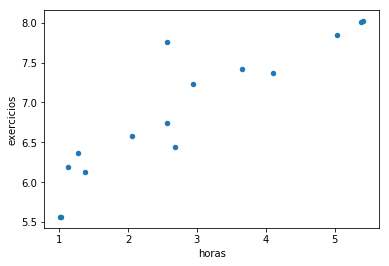

In [3]:
samples = dataset.sample(15, random_state=42)

samples.plot.scatter(x="horas", y="exercicios")
plt.show()

Em primeiro lugar, vamos ajustar uma reta aos nossos dados.

### MACHINE LEARNING TIME!!!!

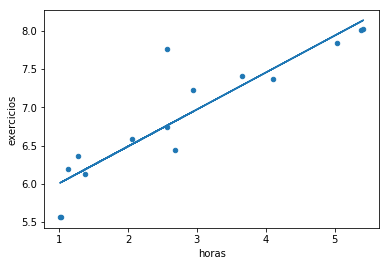

In [4]:
model1 = LinearRegression()
model1.fit(samples[["horas"]], samples["exercicios"])

predictions = (samples
               .assign(predictions = lambda df: model1.predict(df[["horas"]])))
               
predictions.plot.scatter(x="horas", y="exercicios")
plt.plot(predictions["horas"], predictions["predictions"])
plt.show()

In [5]:
r2_score(predictions["exercicios"], predictions["predictions"])

0.823223120462185

Nada mal! Mas nós podemos fazer melhor do que isso!

## Regressão Polinomial

Em primeiro lugar, é preciso lembrar que, teoricamente, [podemos aproximar qualquer função com um polinômio](https://en.wikipedia.org/wiki/Approximation_theory). Então, nós vamos utilizar esse fato para estender regressão linear para regressão polinomial. A ideia é bastante simples: a partir das variáveis existentes, **nós vamos construindo novas variáveis polinomiais e a regressão com elas terá mais capacidade quanto maior o grau do polinômio criado**.

[Mais Sobre Regressão Polinomial...](https://matheusfacure.github.io/2017/02/26/regr-poli/)

![](img/polregr.png)

In [6]:
exponents = range(1, 16)
exp_col_names = [f"horas_{exp}" for exp in exponents]
exp_hours = [samples["horas"] ** exp for exp in exponents]

samples_exp = (samples
               .assign(**dict(zip(exp_col_names, exp_hours)))
               .drop(columns=["horas"]))

# isso é uma forma mais programática de fazer
# samples_exp = (samples
#                .assign(horas_2 = dataset["horas"] ** 2)
#                .assign(horas_3 = dataset["horas"] ** 3)
#                .assign(horas_4 = dataset["horas"] ** 4)
#                ...
#                .assign(horas_6 = dataset["horas"] ** 6))

samples_exp.head()

,exercicios,horas_1,horas_2,horas_3,horas_4,horas_5,horas_6,horas_7,horas_8,horas_9,horas_10,horas_11,horas_12,horas_13,horas_14,horas_15
521,8.013150,5.386292,29.012144,156.267888,841.704518,4533.666533,24419.652962,131531.387771,708466.496067,3.816008e+06,2.055413e+07,1.107106e+08,5.963195e+08,3.211951e+09,1.730051e+10,9.318558e+10
737,7.844930,5.037526,25.376664,127.835596,643.975086,3244.040985,16341.939521,82322.938751,414703.911717,2.089082e+06,1.052380e+07,5.301392e+07,2.670590e+08,1.345316e+09,6.777066e+09,3.413964e+10
740,7.364783,4.104594,16.847693,69.152943,283.844766,1165.067567,4782.129525,19628.700903,80567.851019,3.306983e+05,1.357382e+06,5.571504e+06,2.286876e+07,9.386699e+07,3.852859e+08,1.581442e+09
660,6.743131,2.573175,6.621230,17.037585,43.840689,112.809769,290.279290,746.939445,1922.005989,4.945658e+03,1.272604e+04,3.274634e+04,8.426207e+04,2.168211e+05,5.579185e+05,1.435622e+06
411,6.366609,1.270155,1.613293,2.049131,2.602713,3.305848,4.198938,5.333300,6.774115,8.604173e+00,1.092863e+01,1.388105e+01,1.763108e+01,2.239419e+01,2.844409e+01,3.612839e+01


Com as features polinomiais prontas, podemos ajustar nosso modelo

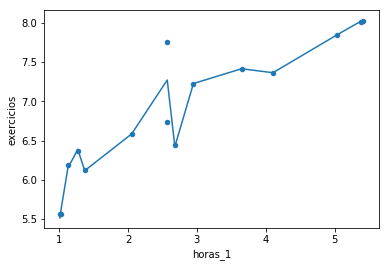

In [7]:
model2 = LinearRegression()
model2.fit(samples_exp[exp_col_names], samples_exp["exercicios"])

pred = (samples_exp
        .assign(predictions = lambda df: model2.predict(df[exp_col_names]))
        .sort_values("horas_1")) # só pra deixar o plot mais bonitinho
               
pred.plot.scatter(x="horas_1", y="exercicios")
plt.plot(pred[["horas_1"]], pred["predictions"])
plt.show()

In [8]:
r2_score(pred["exercicios"], pred["predictions"])

0.9503159019789671

### Qual dos Dois Modelos Acima é Melhor????

## Regularização e Complexidade de Modelo

### Capacidade e Generalização
Vamos ver como nossos dois modeos se saem numa nova amostra de dados

-0.2158686748808072


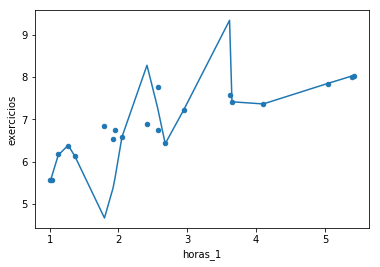

In [9]:
new_samples = dataset.sample(20, random_state=42)
exponents = range(1, 16)
exp_hours = [new_samples["horas"] ** exp for exp in exponents]

new_pred2 = (new_samples
            .assign(**dict(zip(exp_col_names, exp_hours)))
            .assign(predictions = lambda df: model2.predict(df[exp_col_names]))
            .sort_values("horas_1")
            .drop(columns=["horas"]))

print(r2_score(new_pred2["exercicios"], new_pred2["predictions"]))

new_pred2.plot.scatter(x="horas_1", y="exercicios")
plt.plot(new_pred2[["horas_1"]], new_pred2["predictions"])
plt.show()

0.7928711060545443


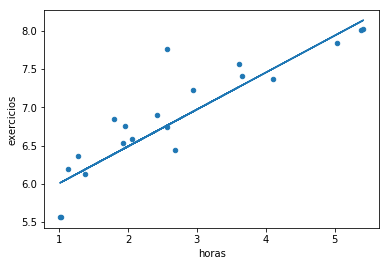

In [10]:
new_pred1 = (new_samples
            .assign(predictions = lambda df: model1.predict(df[["horas"]])))

print(r2_score(new_pred1["exercicios"], new_pred1["predictions"]))

new_pred1.plot.scatter(x="horas", y="exercicios")
plt.plot(new_pred1[["horas"]], new_pred1["predictions"])
plt.show()

E agora? Qual dos dois modelos é o melhor?

# Generalização

Quando nós fazemos um modelo, nós não estamos interessados em prever a variável resposta que temos nos dados. Nós só usamos essa variável `y` para que o nosso modelo aprenda uma relação entre `X` e `y` e depois **queremos que essa relação aprendida pelo modelo generalize para novos dados**.

## Overfitting e Underfitting

Capacidade e generalização são as duas qualidades que gostaríamos que nossos modelos de AM adquirissem: a primeira lhe da força para aprender as regularidades nos dados em que treinamos o modelo; a segunda faz com que ele consiga generalizar o que aprendeu para dados novos. Infelizmente essas duas forças então em polos opostos, de forma que ter mais de uma geralmente significa perder mais da outra. A seguir, vamos detalhar bem como esse tradeoff acontece e como ponderar essas duas forças. 

[Mais Sobre Capacidasde e Generalização...](https://matheusfacure.github.io/AM-Essencial/#Capacidade-e-generaliza%C3%A7%C3%A3o)

### Regularização por Quantidade de Dados
A forma mais fácil de regularizar os seus modelos é adicionando mais dados no set de treino. Assim, ele terá que usar toda a sua capacidade para ajustar apenas o sinal e deixar de lado o ruído.

Exercício: retreine o modelo acima, só que usando todos os dados!

### Regularização Algorítmica

Mas nem sempre você terá dados suficientes para regularizar seu modelo. Por isso, todos os algorítmos de aprendizado de máquina tem um (ou vários) hiperparâmetro que controla a sua complexidade/capacidade. 

"With four parameters I can fit an elephant, and with five I can make him wiggle his trunk."  
-- John von Neumann

### Regressão de  Ridge

Diz a lenda que, para lidar com esse problema, alguns cientistas adicionavam um pequeno valor à diagonal de \\((X^T X)\\), tornando sua inversão mais estável. Ao fazer isso perceberam que a performance do modelo no set de avaliação melhorava. Com o tempo, o teoria estatística se desenvolveu para explicar essa melhora e é isso que veremos aqui. A primeira coisa que precisamos reparar é que \\((X^T X)\\) é uma matriz de covariância, ou seja, ela contém a informação de como cada variável de \\(X\\) correlaciona entre si. A diagonal de \\((X^T X)\\) tem o resultado das covariâncias das variáveis com elas mesmas, ou seja, as variâncias das variáveis de \\(X\\). Assim, adicionar um pequeno valor a diagonal de \\((X^T X)\\) é como aumentar artificialmente a variância nos dados. Isso torna o modelo mais robusto, melhorando sua generalização.

Mais ainda, adicionar um pequeno valor \\(\gamma^2\\) à diagonal de \\((X^T X)\\) é equivalente à adicionar um termo na nossa função custo, que passa de \\( (\pmb{y} - \pmb{\hat{w}}X)^T(\pmb{y} - \pmb{\hat{w}} X)\\) para

$$\mathcal{L} = (\pmb{y} - \pmb{\hat{w}}X)^T(\pmb{y} - \pmb{\hat{w}} X) + \gamma \pmb{\hat{w}}^T \pmb{\hat{w}}$$

Minimziar o primeiro termo da função objetivo acima corresponde a diminuir o erro no set de treino, ao passo que a minimização do segundo termo penaliza a complexidade do modelo. Com esse novo objetivo, o ponto ótimo passa a ser

$$\pmb{\hat{w}} = (X^T X + \gamma^2 I)^{-1} X^T \pmb{y}$$

\\(\pmb{\hat{w}}^T \pmb{\hat{w}}\\) também é chamado de norma L2 de \\(\pmb{\hat{w}}\\), cuja notação é \\(\parallel\pmb{\hat{w}}\parallel ^2\\). Do ponto de vista da otimização, isso adiciona uma segunda força, puxando o parâmetros \(w\) em direção a zero. Quanto maior for o \\(\gamma\\), maior será essa força e maior será a regularização do modelo. O efeito disso é uma suavização da função aprendida pelo modelo. Por outro lado, é sempre bom lembrar que se \\(\gamma\\) for muito grande, a regularização faz com que o modelo perca muita capacidade, sofrendo assim com muito viés.

<img src="https://matheusfacure.github.io/img/tutorial/regularization/regularization_opt.png" style="width: 300px;"/>


[Mais Sobre Regressão de Ridge...](https://matheusfacure.github.io/2017/03/01/l2-reg/)

### Lasso

Uma outra forma de regularizar é com a norma L1. Nesse caso, penalizamos o valor absoluto dos parâmetros.

$$\mathcal{L} = (\pmb{y} - \pmb{\hat{w}}X)^T(\pmb{y} - \pmb{\hat{w}} X) + \gamma \parallel\pmb{\hat{w}}\parallel^1$$

Isso força nosso problema de otimização para zero em várias das diminções. Em termos práticos, Lasso é uma boa para fazer seleção de variáveis mas costuma ser uma regularização muito forte. No geral, Rigde funciona melhor.

<img src="https://cdn-images-1.medium.com/max/1600/1*Jd03Hyt2bpEv1r7UijLlpg.png" style="width: 500px;"/>

Exercício: Usem a Regressão de Ridge para ajustar um modelo regularizado abaixo.

In [11]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(samples_exp[exp_col_names], samples_exp["exercicios"])

# pred = (samples_exp
#         .assign(predictions = lambda df: model.predict(df[exp_col_names]))
#         .sort_values("horas_1")) # só pra deixar o plot mais bonitinho
               
# pred.plot.scatter(x="horas_1", y="exercicios")
# plt.plot(pred[["horas_1"]], pred["predictions"])
# plt.show()

## Dilema De Vies e Variancia

Nós podemos tratar \\(\hat{\beta}\\) como uma variável aleatória. Pense nela como vários parâmetros que seriam aprendidos se utilizássemos apenas uma sub-amostra dos nossos dados para treinar vários modelos. Podemos então definir viés como a diferença entre a esperança dessa variável aleatória e os verdadeiros parâmetros do processo gerador dos dados: \\(E[\hat{\beta}] - \beta\\). Quando essa diferença é zero, temos um estimador ŵ  que é não enviesado, algo que realmente gostaríamos que nossos modelos aprendessem. É importante lembrar que o viés mede a diferença esperada entre a função estimada e o verdadeiro processo gerador de dados.

Além do viés, também precisamos considerar como as nossas estimativas variam com diferentes amostras. Isso pode ser medido pela variância: \\(Var(\hat{\beta})\\). Nós gostaríamos que a variância também fosse baixa, pois não queremos que o tipo de previsão do nosso modelo dependa bruscamente da amostra de dados em que ele foi treinado. Quando um modelo tem muita variância, a qualidade das nossas previsões dependerá muito da amostra que escolhermos para prever.

Matematicamente, podemos mostrar que viés e variância são duas fontes de erro. Mais especificamente, a média do erro quadrado pode ser decomposta em viés e variância:

$$\pmb{MSE= Vies(\hat{w})^2 + Var(\hat{w})}$$

![img](https://matheusfacure.github.io/img/screenshot-from-2017-02-11-17-11-55.png)

## Corss Validation

Para achar o melhor ponto na curva acima, nós trenamos nosso modelo numa amostra e validamos ele em outra. Isso chama validação cruzada. 

![](img/cv101.png)

Vamos voltar aos nossos dados da aula passada:

In [12]:
bike_data = (pd.read_parquet("/Users/matheus.facure/Downloads/bike_data.parquet")
             .dropna()
             .sort_values(["city", "dteday"]))

print(bike_data.shape)
bike_data.head()

(144200, 17)


,city,dteday,season,yr,mkt,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,stock,cnt,target
0,city_0,2011-01-01,1,0,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,997,929,1257.0
1,city_0,2011-01-02,1,0,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,1231,765,1096.0
2,city_0,2011-01-03,1,0,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1395,1395,1430.0
3,city_0,2011-01-04,1,0,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1651,1641,885.0
4,city_0,2011-01-05,1,0,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,2334,1671,1210.0


In [13]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score

### Feature Engineering
Vamos criar variáveis que são exatamente iguais a cnt, só que no período anterior

In [14]:
lags = range(1, 14)

dataset = (bike_data
           .assign(**{f"cnt_l{l}": bike_data.groupby("city")["cnt"].shift(l) for l in lags}))
           
dataset.head()

,city,dteday,season,yr,mkt,mnth,holiday,weekday,workingday,weathersit,...,cnt_l4,cnt_l5,cnt_l6,cnt_l7,cnt_l8,cnt_l9,cnt_l10,cnt_l11,cnt_l12,cnt_l13
0,city_0,2011-01-01,1,0,0,1,0,6,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,city_0,2011-01-02,1,0,0,1,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,city_0,2011-01-03,1,0,0,1,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,city_0,2011-01-04,1,0,0,1,0,2,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,city_0,2011-01-05,1,0,0,1,0,3,1,1,...,929.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


E vamos adicionar variáveis dummies.

In [15]:
catge_features = ["season","yr","mnth","weekday","weathersit"]
dataset = pd.get_dummies(dataset, columns=catge_features, drop_first=True)
dataset.head()

,city,dteday,mkt,holiday,workingday,temp,atemp,hum,windspeed,stock,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,city_0,2011-01-01,0,0,0,0.344167,0.363625,0.805833,0.160446,997,...,0,0,0,0,0,0,0,1,1,0
1,city_0,2011-01-02,0,0,0,0.363478,0.353739,0.696087,0.248539,1231,...,0,0,0,0,0,0,0,0,1,0
2,city_0,2011-01-03,0,0,1,0.196364,0.189405,0.437273,0.248309,1395,...,0,0,1,0,0,0,0,0,0,0
3,city_0,2011-01-04,0,0,1,0.200000,0.212122,0.590435,0.160296,1651,...,0,0,0,1,0,0,0,0,0,0
4,city_0,2011-01-05,0,0,1,0.226957,0.229270,0.436957,0.186900,2334,...,0,0,0,0,1,0,0,0,0,0


### Valores Faltantes

In [16]:
dataset.isna().mean()

city            0.000000
dteday          0.000000
mkt             0.000000
holiday         0.000000
workingday      0.000000
temp            0.000000
atemp           0.000000
hum             0.000000
windspeed       0.000000
stock           0.000000
cnt             0.000000
target          0.000000
cnt_l1          0.001387
cnt_l2          0.002774
cnt_l3          0.004161
cnt_l4          0.005548
cnt_l5          0.006935
cnt_l6          0.008322
cnt_l7          0.009709
cnt_l8          0.011096
cnt_l9          0.012483
cnt_l10         0.013870
cnt_l11         0.015257
cnt_l12         0.016644
cnt_l13         0.018031
season_2        0.000000
season_3        0.000000
season_4        0.000000
yr_1            0.000000
mnth_2          0.000000
mnth_3          0.000000
mnth_4          0.000000
mnth_5          0.000000
mnth_6          0.000000
mnth_7          0.000000
mnth_8          0.000000
mnth_9          0.000000
mnth_10         0.000000
mnth_11         0.000000
mnth_12         0.000000


In [17]:
dataset = dataset.dropna()

## Variáveis e Target

In [18]:
non_features = ["city", "dteday", "target"]

# similar to 
# features = list(filter(lambda col: col not in non_features, dataset.columns))
features = [col for col in dataset.columns if col not in non_features]
target = "target"

## Pipelines

Em ML, um modelo raramente é apenas o algorítmo de aprendizado de máquina e envolve também passos de pré-processamento dos dados. Esses passo também precisam ser estimados nos dados de treino e aplicados nos dados de teste ou validação. Alguns exemplos são

* Normalização das Features
* Criar variáveis dummies

In [19]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target],
                                                    test_size=0.5, random_state=42)

model = make_pipeline(StandardScaler(), # para treinar mais rápido
                      Ridge())

# treinamos em um dataset
model.fit(X_train, y_train)

# validamos em outro dataset
print("Train result:", model.score(X_train, y_train)),
print("Test result:", model.score(X_test, y_test))

Train result: 0.6548686522870273
Test result: 0.6521090317287668


## K-Fold Cross Validation

Em vez de fazer validação cruzada uma única vez, podemos repetir o processo para vários sub-samples. Isso nos dará uma estimativa da variância do nosso modelo.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [20]:
scores = cross_val_score(model, dataset[features], dataset[target], cv=10)    
scores

array([0.63807944, 0.65434312, 0.65490763, 0.65886135, 0.65847631,
       0.66011409, 0.6574404 , 0.6588355 , 0.64870754, 0.6427711 ])

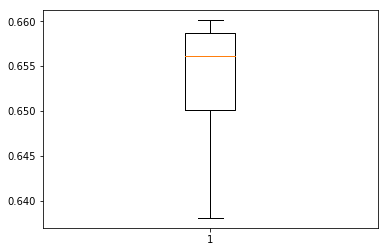

In [21]:
plt.boxplot(scores)
plt.show()

### Beleza... Aí você sai de uma aula de ML 101 e acha bem de boas né? Só seprar os dados em treino e teste, estimar meu modelo no treino e avaliar no test
Geralmente (muito geralmente, tipo o tempo todo. Serio!), os seus resultados de produção são beeem piores do que os dados de teste. O que acontece?

. 

Durante o treino do seu modelo, os dados são sempre os mesmos. Eles são estaticos. Quando você vai pra produção, seus dados estão sempre mudando!

* Seus dados mudam no tempo (sempre! sempre sempre sempre!!!)
* Seus dados mudam no espaço

## Cross Validation Temporal

![](img/cv-real-world.png)

In [22]:
time_column = "dteday"
dataset[time_column].min(), dataset[time_column].max()

(Timestamp('2011-01-14 00:00:00'), Timestamp('2012-12-21 00:00:00'))

In [23]:
train_start_date = "2011-01-01"
train_end_date = "2012-03-01"
holdout_start_date = "2012-05-01"
holdout_end_date = "2012-12-21"


train_set = dataset[
    (dataset[time_column] >= train_start_date) & (dataset[time_column] < train_end_date)]

test_set = dataset[
        (dataset[time_column] >= holdout_start_date) & (dataset[time_column] < holdout_end_date)]

X_train, X_test, y_train, y_test = train_set[features], test_set[features], train_set[target], test_set[target]

model = make_pipeline(StandardScaler(),
                      Ridge(1e6))

# treinamos em um dataset
model.fit(X_train, y_train)

# validamos em outro dataset
print("Train result:", model.score(X_train, y_train)),
print("Test result:", model.score(X_test, y_test))

Train result: 0.3506208737584583
Test result: -0.6214834686164761


Você consegue ajustar o parâmetro de complexidade do seu modelo para ter um bom resultado?

## Cross Validação no Tempo e Espaço

![](img/cv-time-space.png)

In [24]:
space_column="city"

train_period = dataset[
        (dataset[time_column] >= train_start_date) & (dataset[time_column] < train_end_date)]

outime_holdout = dataset[
        (dataset[time_column] >= train_end_date) & (dataset[time_column] < holdout_end_date)]

train_period_space = np.sort(train_period[space_column].unique())

holdout_space = np.random.choice(train_period_space,
                                 int(0.3 * len(train_period_space)), replace=False)

train_set = train_period[~train_period[space_column].isin(holdout_space)]
intime_outspace_hdout = train_period[train_period[space_column].isin(holdout_space)]
outime_outspace_hdout = outime_holdout[outime_holdout[space_column].isin(holdout_space)]

In [25]:
X_train, X_test, y_train, y_test = train_set[features], outime_outspace_hdout[features], train_set[target], outime_outspace_hdout[target]

model = make_pipeline(StandardScaler(),
                      Ridge(1e0))

# treinamos em um dataset
model.fit(X_train, y_train)

# validamos em outro dataset
print("Train result:", model.score(X_train, y_train)),
print("Test result:", model.score(X_test, y_test))

Train result: 0.5532027570411512
Test result: 0.17674169139037121


# Bonus: Casos Reais

Monedas PPT